# Tarea 3. Visión computacional
Guillermo Segura Gómez

## Ejercicio 1
**Implement your own fundamental matrix estimation function that will satisfy the following requirements**:
- It will take matchings computed automatically (ORB or SIFT features).
- It will use the 8-point algorithm within RANSAC robust estimation process to discard outliers (please code this part by yourself, do not use the OpenCV function).
- It will be tested on several pairs of images, and the epipolar lines will be displayed.
- It will normalize the points before estimating the fundamental matrix and de-normalize the result.

---

**La geometría epipolar** es la geometría proyectiva intrínseca entre dos vistas diferentes. Es independiente de la estructura de la escena y solo depende de los parámetros internos de las cámaras (de ahi el nombre "intrínseca"), y la posición relativa [1] (Capítulo 9).
Los elementos principales de la geometría epipolar incluyen:

- Puntos Epipolares: Son los puntos de intersección de la línea que une los centros de las dos cámaras (llamada línea base) con los planos de imagen de las cámaras.
- Líneas Epipolares: Cada punto en una imagen determina una línea en la otra imagen. Esta línea es el lugar geométrico de todos los puntos que podrían corresponder al punto original en la otra vista.
- Plano Epipolar: Cualquier plano que contenga la línea base. Un punto en el espacio 3D y sus proyecciones en las dos imágenes definen un plano epipolar.

**La matriz fundamental** encapsula la geometría intrínseca. Es una representación algebraica de la geometría epipolar. Es una matriz $3 \times 3$ de rango 2 que relaciona las coordenadas de un punto en una imagen con las coordenadas de su punto correspondiente en otra imagen. Si tenemos un punto $x$ en la primera imagen y su correspondiente $x'$ en la segunda imagen, la relación que los vincula a través de la matriz fundamental es $x'^T F x = 0$ [1]. La matriz fundamental tiene las siguientes propiedades:

- Relación Epipolar: La ecuación $x'^T F x = 0$ expresa la restricción epipolar, que dice que el punto $x'$, la línea epipolar correspondiente a $x$, y el punto epipolar en la segunda imagen deben ser colineales.
- Estimación de Correspondencias: La matriz fundamental se puede utilizar para estimar correspondencias entre puntos en pares de imágenes, facilitando la búsqueda de puntos correspondientes al restringir la búsqueda a las líneas epipolares correspondientes.
- Reconstrucción de la Geometría de la Escena: Aunque la matriz fundamental no proporciona información directa sobre la distancia de los puntos de la escena, se puede utilizar para reconstruir la estructura de la escena y la posición relativa de las cámaras hasta una escala desconocida (reconstrucción proyectiva).

La matriz fundamental depende de lo siguiente: 

- Parámetros Intrínsecos de las Cámaras: La matriz fundamental relaciona las vistas de dos puntos a través de la geometría epipolar. Aunque la matriz fundamental no requiere explícitamente estos parámetros para su cálculo, la relación entre las vistas que describe está condicionada por cómo las cámaras capturan las imágenes. Por ejemplo el centro óptico de las cámaras cambia, modificando el plano epipolar al cambiar la *baseline* [1].
- Parámetros Extrínsecos de las Cámaras: Lo que importa son los parámetros extrínsecos relativos entre las dos cámaras, es decir, cómo una cámara está orientada y posicionada con respecto a la otra, ya que modifica las relaciones epipolares. Es la posición relativa de la que se habló al inicio de la discusión. 

**Oriented FAST and Rotated BRIEF**

ORB fue desarrollado por los laboratorios de OpenCV, por Ethan Rublee, Vincent Rabaud, Kurt Konolige, y Gary R. Bradski en 2011, como una eficiente alternativa a SIFT (Scale-Invariant Feature Transform) y SURF. ORB es de libre acceso mientras que SIFT es un algoritmo patentado.Estos algoritmos detectan puntos únicos en las imágenes que son invariantes a cambios de escala, rotación y parcialmente invariantes a cambios de iluminación y perspectiva. Los "matchings" o emparejamientos son los pares de puntos correspondientes entre las dos imágenes que se han identificado como similares según las características extraídas por ORB o SIFT. [2]

**Cálculo numérico de la matriz fundamental**

Usualmente la matriz fundamental F, es algo complicado de calcular. No existe solución analítica sencilla para el cálculo de la matriz, esto debido a diferentes factores, tales como el ruido en la imagen, o la complejidad de las imágenes. Para estimar la matriz fundamental se tienen algunas técnicas numéricas. Una de estas técnicas es el *algoritmo normalizado de 8 puntos*.

Este algoritmo es la manera mas simple de calcular la matriz fundamental y no implica más que la construcción y la solución (de mínimos cuadrados) de un conjunto de ecuaciones lineales [1] (Capítulo 11). 

El algoritmo se muestra a continuación:

Objective
$\overline{\text { Given } n} \geq 8$ image point correspondences $\left\{\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}\right\}$, determine the fundamental matrix $\mathrm{F}$ such that $\mathbf{x}_i^{\prime \top} \mathrm{F} \mathbf{x}_i=0$.

Algorithm
* (i) Normalization: Transform the image coordinates according to $\hat{\mathbf{x}}_i=\operatorname{Tx}_i$ and $\hat{\mathbf{x}}_i^{\prime}=$ $\mathrm{T}^{\prime} \mathrm{x}_i^{\prime}$, where $\mathrm{T}$ and $\mathrm{T}^{\prime}$ are normalizing transformations consisting of a translation and scaling $\sqrt{2}$
* (ii) Find the fundamental matrix $\hat{F}^{\prime}$ corresponding to the matches $\hat{\mathbf{X}}_i \leftrightarrow \hat{\mathbf{x}}_i^{\prime}$ by
    - (a) Linear solution: Determine $\hat{F}$ from the singular vector corresponding to the smallest singular value of $\hat{A}$, where $\hat{A}$ is composed from the matches $\hat{\mathbf{x}}_i \leftrightarrow \hat{\mathbf{x}}_i^{\prime}$ as defined in (11.3).
    - (b) Constraint enforcement: Replace $\hat{F}$ by $\hat{F}^{\prime}$ such that $\operatorname{det} \hat{F}^{\prime}=0$ using the SVD.
* (iii) Denormalization: $\operatorname{Set} F=\mathrm{T}^{\prime \mathrm{T}} \hat{\mathrm{F}}^{\prime} \mathrm{T}$. Matrix $\mathrm{F}$ is the fundamental matrix corresponding to the original data $\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}$.

RANSAC (RANdom SAmple Consensus) es un método iterativo utilizado para estimar los parámetros de un modelo matemático a partir de un conjunto de datos que contiene un número significativo de valores atípicos (outliers). La idea básica detrás de RANSAC es seleccionar aleatoriamente un mínimo número de puntos necesarios para determinar los parámetros del modelo, ajustar el modelo a esos puntos, y luego determinar cuántos puntos del conjunto total de datos se ajustan bien a este modelo estimado. Este proceso se repite un número fijo de veces, y el mejor modelo (es decir, el modelo con el mayor número de inliers) se selecciona como la estimación final. [1]

Vamos a utilizar RANSAC para calcular la mejor matriz para nuestros puntos. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

Primero necesitamos leer las imágenes de dos vistas, y utilizar ORB para detectar los puntos clave.

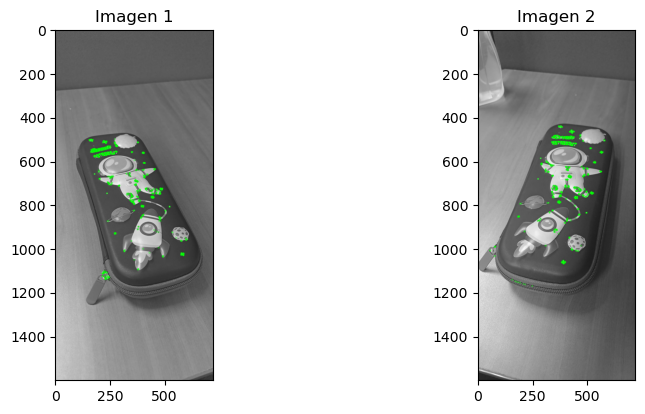

In [11]:
#  Leer imágenes
images = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Pencilcase/*.jpeg')

# Inicializamos la figura para graficar
plt.figure(figsize=(10, len(images) * 5))

for i, fname in enumerate(images):
    # Leer la imágen
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Inicializar ORB
    orb = cv2.ORB_create(nfeatures=1000)

    # Detectar puntos claves y descriptores
    puntosClave, descriptores = orb.detectAndCompute(img, None)

    # Dibujar puntos clave
    imagenPuntosClave = cv2.drawKeypoints(img, puntosClave, None, color=(0, 255, 0), flags=0)
    
    # Mostrar las imágenes
    plt.subplot(len(images), 2, i + 1)
    plt.imshow(imagenPuntosClave)
    plt.title(f'Imagen {i + 1}')

plt.show()

Ahora definimos la función del algoritmo normalizado de 8 puntos.

In [12]:
# Función que normaliza los puntos para que el centroide esté en el origen y el promedio de las distancias al origen sea sqrt(2).
def normalizarPuntos(puntos):
    # Cálculo del centroide
    centroid = np.mean(puntos, axis=0)
    puntos_norm = puntos - centroid

    # Escalamiento de las distancias
    distancias = np.linalg.norm(puntos_norm, axis=1)
    escala = np.sqrt(2) / np.mean(distancias)

    # Construcción de matriz de normalización
    matriz_norm = np.array([[escala, 0, -escala * centroid[0]],
                            [0, escala, -escala * centroid[1]],
                            [0, 0, 1]])
    puntos_norm = np.dot(matriz_norm, np.hstack((puntos, np.ones((puntos.shape[0], 1)))).T).T
    return puntos_norm, matriz_norm

In [13]:
def Norm8Points(xi, xip):
    # Normalizar los puntos
    xi_norm, T1 = normalizarPuntos(xi)
    xip_norm, T2 = normalizarPuntos(xip)
    
    # Construir la matriz A
    A = np.zeros((len(xi), 9))
    for i, (p1, p2) in enumerate(zip(xi_norm, xip_norm)):
        x1, y1, _ = p1
        x2, y2, _ = p2
        A[i] = [x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1]
    
    # Descomposición en valores singulares de A y extracción de F
    U, D, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    
    # Forzar a que F sea de rango 2
    Uf, Df, Vtf = np.linalg.svd(F)
    Df[2] = 0  # Poner a cero el valor singular más pequeño
    F = Uf @ np.diag(Df) @ Vtf
    
    # Desnormalizar la matriz fundamental
    F = T2.T @ F @ T1
    

Una vez con el código del algoritmo de 8 puntos implementado, podemos implementar la función que hace una estimación de la matriz fundamental de dos imágenes agregando RANSAC para estimar la mejor matriz para nuestras imágenes. 

In [ ]:
def FundamentalMatrix():
    return 0

## Referencias

[1] Hartley, Richard, and Andrew Zisserman. Multiple view geometry in computer vision. Cambridge university press, 2003.

[2] Tyagi, Deepanshu. “Introduction to ORB (Oriented FAST and Rotated BRIEF).” Medium. Medium, 2019. Online. Internet. 24 Feb. 2024. [Available](medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
